# Prior

In [1]:
import numpy as np
from matplotlib import pyplot as plt

import os
os.chdir('../../../..')
print(os.getcwd())

c:\Users\Paul\Documents\X\4A\S1\HMM\poisson_network_models


In [2]:
from src.smc_2324_project.simulate.generate_dataset import *
from src.smc_2324_project.tempering.base_dist import *
from src.smc_2324_project.tempering.tempering import *

from src.smc_2324_project.variational.posterior_gamma import hessian, sample_from_gamma
from src.smc_2324_project.variational.posterior_nu import sample_from_nu
from src.smc_2324_project.variational.SBM_regression import VEM

In [3]:
# hyperparameters
n, k, p = 40, 3, 4
gamma_0 = np.array([0.6,0.6,0.6]+[1, 0, 3, 1.1, 2.2, 0.1, -0.3])
V_0 = np.eye(len(gamma_0))
e_0 = 3 * np.ones(k)

# prior
theta_prior = define_theta_prior(gamma_0, V_0, e_0)
prior = define_prior(theta_prior, n)

# Dataset

In [4]:
# generate dataset
alpha, beta, nu = generate_network_params(k, gamma_0, V_0, e_0)
X = generate_covariates(n, p)
sample_from_network((alpha, beta, nu), X)
theta = (alpha,beta,nu)
Z, Y = sample_from_network(theta,X, return_Z=True)

# VEM inference

In [5]:
# VEM
particle = prior.rvs()[0]
gamma_init, nu_init = particle["theta"]["gamma"], particle["theta"]["nu"]
tau_init = np.array([nu for i in range(n)])
inferred_gamma, inferred_nu, inferred_tau = VEM(Y, X, gamma_init, nu_init, tau_init)
hess = hessian(Y, X, inferred_tau, inferred_gamma)

number of iterations: 15
terminal gamma, nu: (array([1.13053315, 1.13160518, 1.13115723, 1.132027  , 1.13086031,
       1.13120977, 1.44110941, 0.33245377, 0.09587971, 0.26979829]), array([0.3969287 , 0.29948938, 0.30358192]))


In [6]:
# posterior distribution
e_tilde = e_0 + np.sum(inferred_tau,axis=0)
invV0 = np.linalg.inv(V_0)
cov_gamma = np.linalg.inv((invV0 - hess))
mean_gamma = cov_gamma @ (invV0 @ gamma_0 - hess @ inferred_gamma)

In [7]:
# gamma_prior = prior.laws['theta'].laws['gamma']
# gamma_base_dist = base_dist.laws['theta'].laws['gamma']

In [8]:
from particles.distributions import *

# relaxation
relaxation = 0.4
# inferred_nu = (1-relaxation) * inferred_nu + relaxation * nu
cov_gamma = (1-relaxation) * cov_gamma + relaxation * np.eye(len(gamma_0)) # SDP constraint

base_dist = define_VEM_base_dist(inferred_tau, inferred_nu, mean_gamma, cov_gamma)
mixture_dist = Mixture([1-relaxation, relaxation], base_dist, prior)

# Logtarget and model

In [9]:
# target
compute_llh_target = define_llh_target(prior, X, Y, k)

In [10]:
from particles.smc_samplers import TemperingBridge

class ToyBridge(TemperingBridge):
    def logtarget(self, theta):
        return compute_llh_target(theta)

In [11]:
toy_bridge = ToyBridge(base_dist=base_dist)

# Move

In [12]:
move = FixedLenMCMCSequence(mcmc=CustomGibbs(k, e_0, e_tilde), len_chain=5)

# AdaptiveTempering

In [13]:
import particles

# finally
fk_tpr = FlexibeAdaptiveTempering(model=toy_bridge, len_chain=100, 
                                  move=move, wastefree=False,
                                  tempering_step_size = 0.5) # tempering_step_size = 1-tau_1
alg = particles.SMC(fk=fk_tpr, N=200, ESSrmin=0.8,
                    store_history=True, verbose=True)
alg.run()

t=0, ESS=100.00, tempering exponent=8.66e-05
t=1, Metropolis acc. rate (over 1 steps): 0.075, ESS=100.00, tempering exponent=0.000341
t=2, Metropolis acc. rate (over 1 steps): 0.050, ESS=100.00, tempering exponent=0.000753
t=3, Metropolis acc. rate (over 1 steps): 0.050, ESS=100.00, tempering exponent=0.00109
t=4, Metropolis acc. rate (over 1 steps): 0.045, ESS=100.00, tempering exponent=0.00134
t=5, Metropolis acc. rate (over 1 steps): 0.050, ESS=100.00, tempering exponent=0.00157
t=6, Metropolis acc. rate (over 1 steps): 0.035, ESS=100.00, tempering exponent=0.00189
t=7, Metropolis acc. rate (over 1 steps): 0.040, ESS=100.00, tempering exponent=0.00258
t=8, Metropolis acc. rate (over 1 steps): 0.035, ESS=100.00, tempering exponent=0.00351
t=9, Metropolis acc. rate (over 1 steps): 0.050, ESS=100.00, tempering exponent=0.00486
t=10, Metropolis acc. rate (over 1 steps): 0.040, ESS=100.00, tempering exponent=0.00629
t=11, Metropolis acc. rate (over 1 steps): 0.010, ESS=100.00, tempering 

# Convergence plot

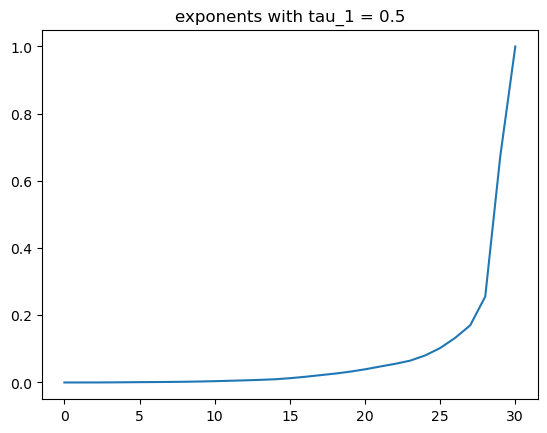

In [ ]:
# exponents
exponents = alg.X.shared["exponents"]
plt.plot(exponents)
plt.title("exponents with tau_1 = 0.5")
plt.show()

In [ ]:
gamma_test = alg.hist.X[0].theta["theta"]["gamma"]
print("gamma_test = ", gamma_test.shape)

gamma_test =  (200, 10)


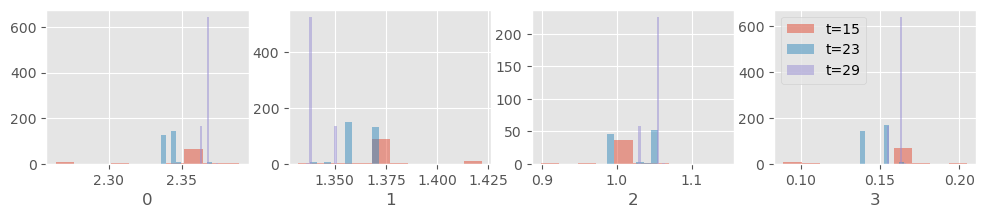

In [ ]:
# beta distribution
plt.style.use('ggplot')
fig = plt.figure(figsize=(12, 2))
num_exponents = len(exponents)
for beta_idx in range(4):
    plt.subplot(1, 4, beta_idx+1)
    for t in [num_exponents//2, int(3/4*num_exponents), num_exponents-2]:
        assert t < len(alg.hist.X), "t={} is greater than {}".format(t, len(alg.hist.X))
        beta_i = alg.hist.X[t].theta["theta"]["gamma"][:,k*(k+1)//2+beta_idx]
        weights = alg.hist.wgts[t].W
        plt.hist(beta_i, weights=weights, label="t=%i" % t, 
                 alpha=0.5, density=True)
    plt.xlabel(beta_idx)
plt.legend()

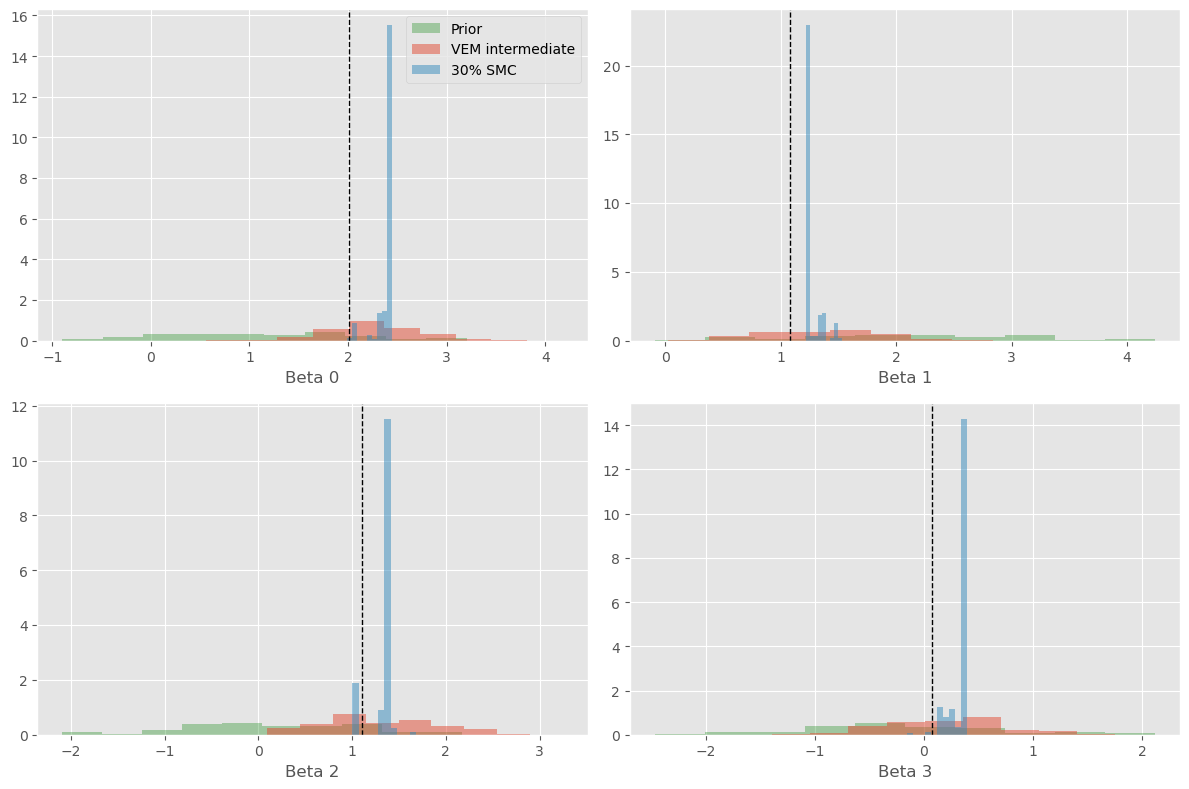

In [ ]:
# settings
plt.style.use('ggplot')
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
num_exponents = len(exponents)

beta_prior_mean = gamma_0[-p:]
beta_prior_cov = V_0[-p:, -p:]
beta_prior_samples = multivariate_normal.rvs(mean=beta_prior_mean, cov=beta_prior_cov, size=100)

# iterate over beta
for beta_idx in range(4):
    row, col = divmod(beta_idx, 2)
    ax = axes[row, col]

    # prior
    ax.hist(beta_prior_samples[:, beta_idx], alpha=0.3, color='green', density=True, label='Prior')

    for t in [0, int(0.3*num_exponents)]:
        # label
        if t == 0:
            label = "VEM intermediate"
        else:
            label = "30% SMC"

        # plot
        assert t < len(alg.hist.X), "t={} is greater than {}".format(t, len(alg.hist.X))
        beta_i = alg.hist.X[t].theta["theta"]["gamma"][:, k * (k + 1) // 2 + beta_idx]
        weights = alg.hist.wgts[t].W
        ax.hist(beta_i, weights=weights, label=label, alpha=0.5, density=True) #)

    # true value
    ax.axvline(beta[beta_idx], color='black', linestyle='dashed', linewidth=1)

    ax.set_xlabel("Beta {}".format(beta_idx))

axes[0, 0].legend()
plt.tight_layout()
plt.show()

## Saving the results

In [ ]:
import pickle

with open("data/hyperparams_tuning/tempering_1.pkl", "wb") as f:
    pickle.dump(alg.X, f)

## About $\tau$

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

C:\Users\Paul\AppData\Local\Temp\ipykernel_2616\599377257.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(Y, 'ward')


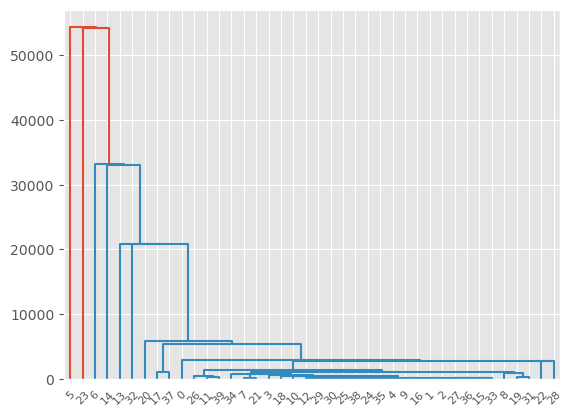

In [ ]:
Z = linkage(Y, 'ward')
d = dendrogram(Z)

In [ ]:
res = [(d['leaves'][i], int(d['leaves_color_list'][i][-1])) for i in range(n)]
tau = np.zeros((n, k))
for i, r in enumerate(res):
    tau[i, r[1]-1] = 1

In [ ]:
np.sum(Y, axis=0)

array([3.4760e+03, 2.0000e+00, 0.0000e+00, 1.0520e+03, 2.5000e+01,
       4.1050e+04, 2.7103e+04, 4.9100e+02, 1.7000e+03, 1.1000e+01,
       1.1630e+03, 5.3800e+02, 3.1200e+02, 1.5996e+04, 2.4973e+04,
       2.4900e+02, 3.0000e+00, 2.8810e+03, 4.3100e+02, 1.3150e+03,
       7.3550e+03, 3.8100e+02, 2.8840e+03, 3.9618e+04, 5.6000e+01,
       2.3400e+02, 1.3340e+03, 2.7500e+02, 2.7490e+03, 2.6200e+02,
       1.5200e+02, 7.3000e+02, 1.5156e+04, 2.3600e+02, 1.0090e+03,
       5.8000e+01, 2.6300e+02, 3.8580e+03, 1.2800e+02, 1.1210e+03])

In [ ]:
np.sum(tau, axis=0)

array([38.,  0.,  2.])